# Introduction

How much of the TPC ionizing hits would come from delayed neutron? 

For example, one source for such delayed hits is from the neutron components of the hadronic shower in the hadronic calorimeter, which then travel and scattered around the detector for a long period of time. In fact, delayed calorimeter energy deposition was proposed to separate hadronic and EM components of the shower inside a hadronic calorimeter. 

Here is one way to quantify this effect by comparing our standard production setup `Run40` using `FTFP_BERT` physics list with special test `Run41` using `FTFP_BERT_HP` physics list. The later keep track of the late neutron for a very long time in Geant4 time scale. The events in both cases come from 0-20 fm HIJING AuAu collision at t=0. Then we track hits in the TPC up to 1ms (with over flow bin beyond that). 

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.24/06


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.2`


# Initialization

In [4]:
%%cpp -d


#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [5]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");
gSystem->Load("libg4eval")

sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode
(int) 0


# Inputs and file checks

In [6]:
%%cpp
TFile *file = new TFile("data/MDC2_Run40_FTFP_BERT.g4hits.list.DSTReader.root");
TTree * T = nullptr; 

file->GetObject("T", T);

{
    T->Draw(">>elist", "Entry$<1000", "entrylist");
    TEntryList *elist = (TEntryList*)gDirectory->Get("elist");
    T->SetEntryList(elist);
    
    cout <<"Reference data MDC2_Run40_FTFP_BERT with "<<T->GetEntries("1")<<" events"<<endl;
}


TFile *file_HP = new TFile("data/MDC2_Run41_FTFP_BERT_HP.g4hits.list.DSTReader.root");
TTree * T_HP = nullptr; 

file_HP->GetObject("T", T_HP);

{
    T_HP->Draw(">>elist", "Entry$<1000", "entrylist");
    TEntryList *elist = (TEntryList*)gDirectory->Get("elist");
    T_HP->SetEntryList(elist);
    
    cout <<"Test data MDC2_Run41_FTFP_BERT_HP with "<<T_HP->GetEntries("1")<<" events"<<endl;
}

Reference data MDC2_Run40_FTFP_BERT with 10 events
Test data MDC2_Run41_FTFP_BERT_HP with 10 events


In [7]:
# ROOT.T.Show(0)

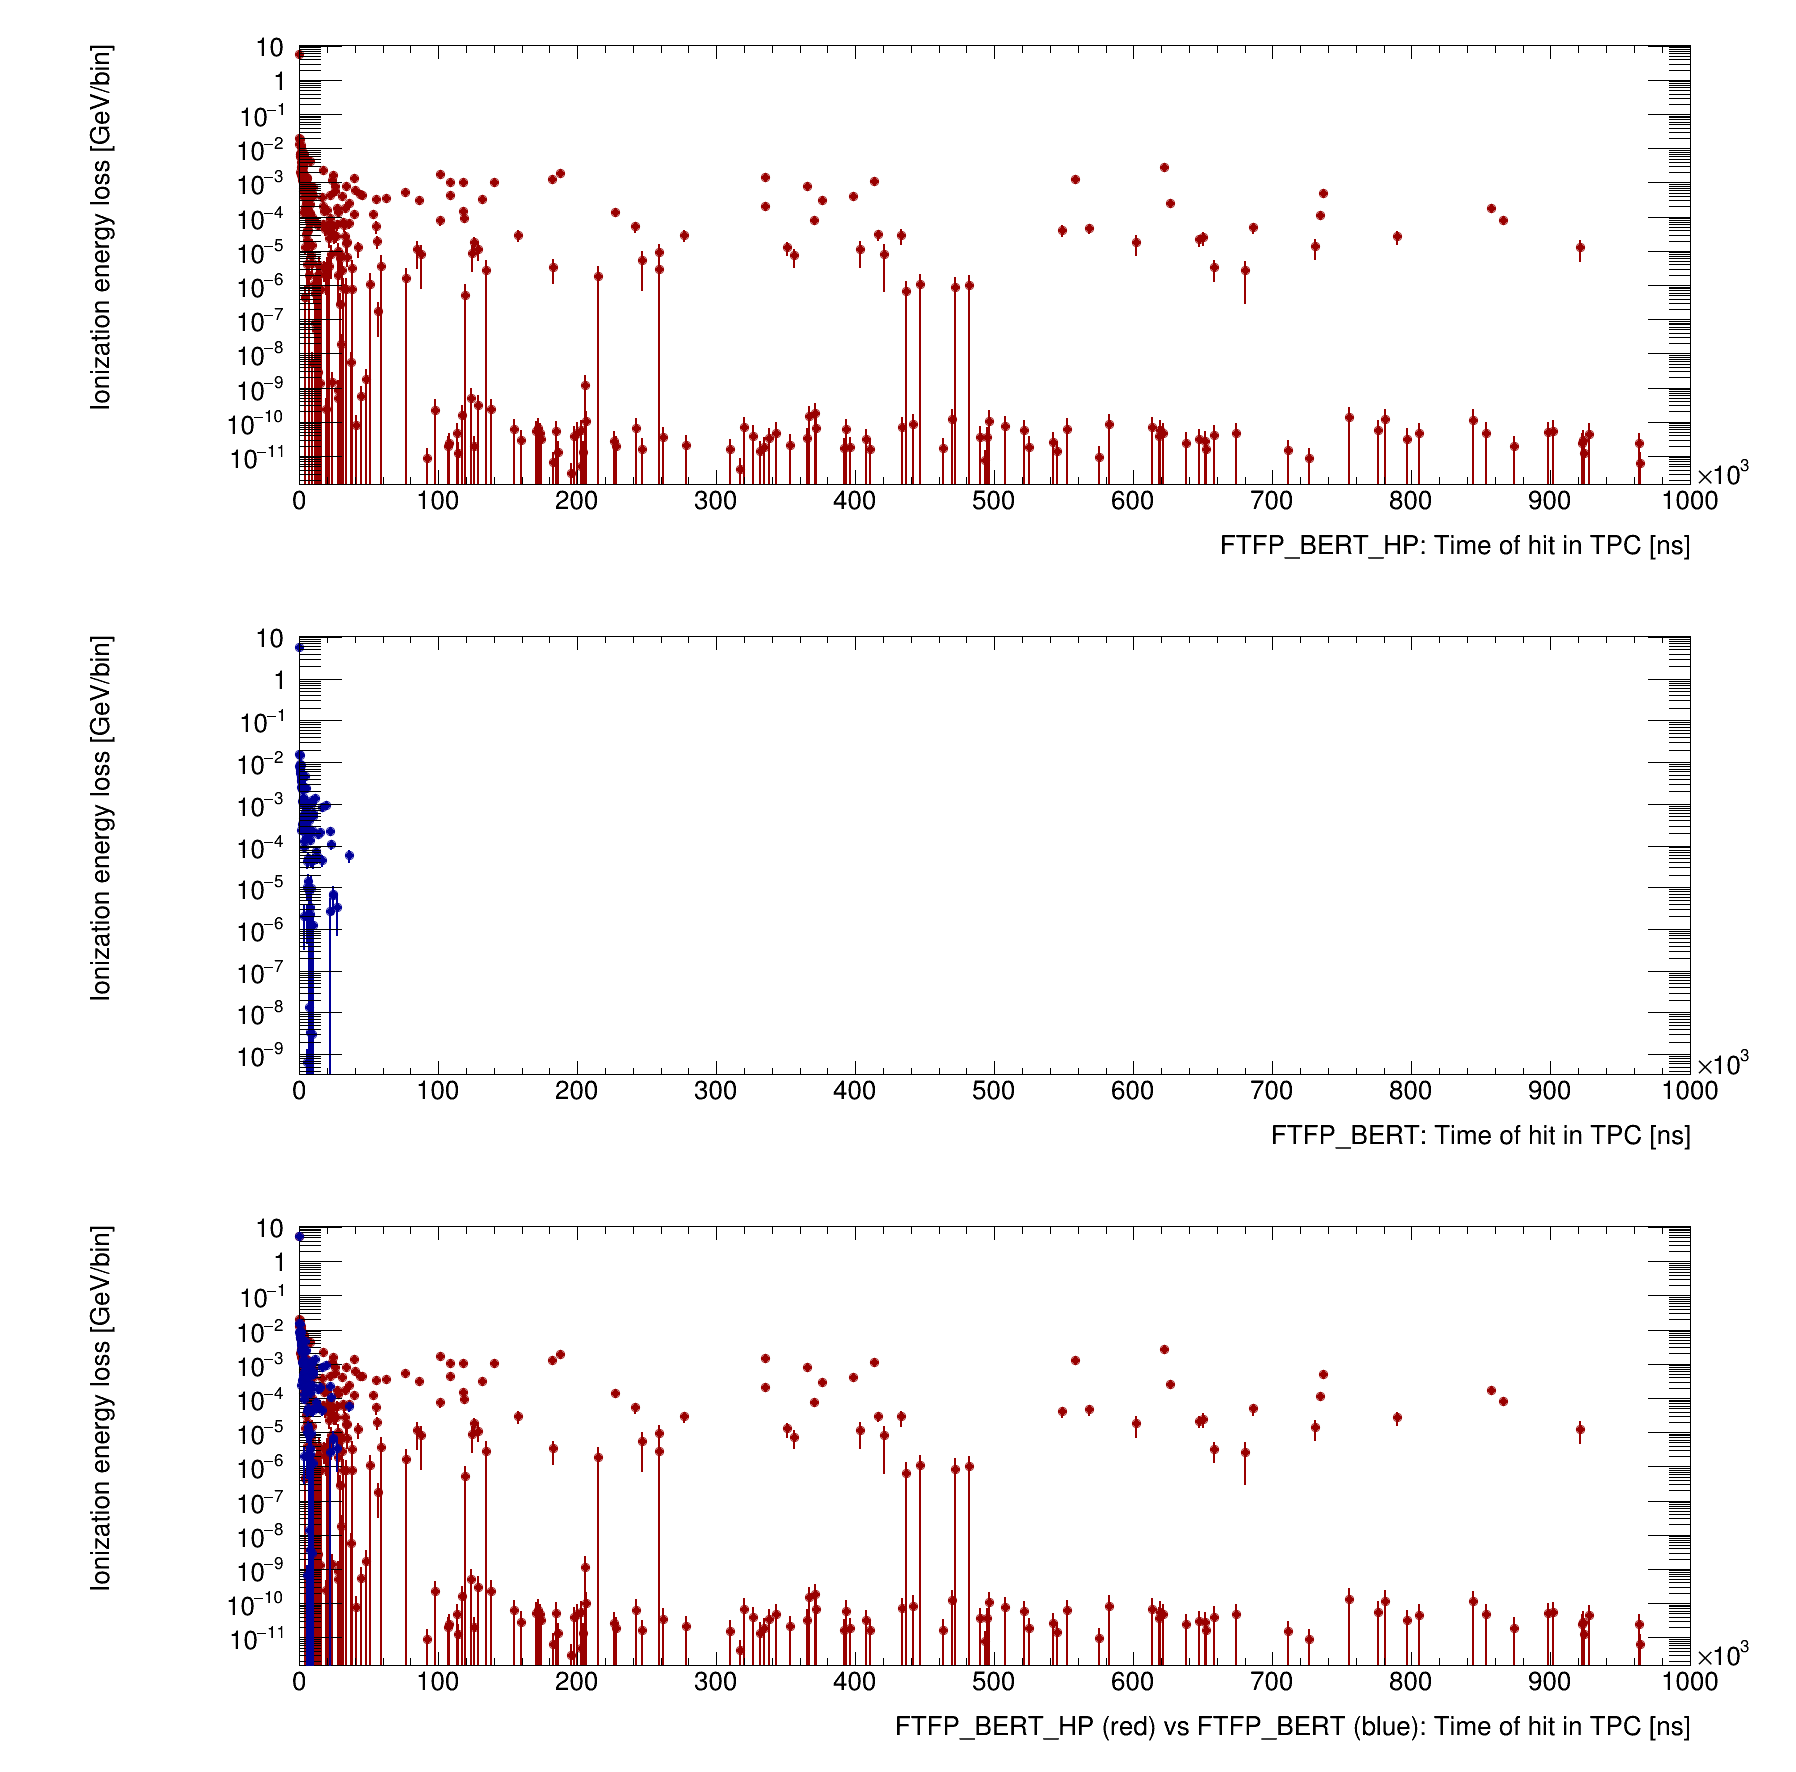

In [8]:
%%cpp

TH1 * h_eIonTPCHitTime_HP = new TH1F("h_eIonTPCHitTime_HP",";FTFP_BERT_HP: Time of hit in TPC [ns];Ionization energy loss [GeV/bin]",10000,0,1000000);
TH1 * h_eIonTPCHitTime = new TH1F("h_eIonTPCHitTime",";FTFP_BERT: Time of hit in TPC [ns];Ionization energy loss [GeV/bin]",10000,0,1000000);
{

    auto c1 = new TCanvas(TString("TimeScan") ,
                        TString("TimeScan"),
                        1800, 1800);

    c1->Divide(1, 3);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        h_eIonTPCHitTime_HP->SetMarkerColor(kRed+2);
        h_eIonTPCHitTime_HP->SetLineColor(kRed+2);
        T_HP->Draw("G4HIT_TPC[].t[0]>>h_eIonTPCHitTime_HP","G4HIT_TPC[].edep");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        h_eIonTPCHitTime->SetMarkerColor(kBlue+2);
        h_eIonTPCHitTime->SetLineColor(kBlue+2);
        T->Draw("G4HIT_TPC[].t[0]>>h_eIonTPCHitTime","G4HIT_TPC[].edep");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        TH1 * h = (TH1 *) h_eIonTPCHitTime_HP->DrawClone();
        h->GetXaxis()->SetTitle("FTFP_BERT_HP (red) vs FTFP_BERT (blue): Time of hit in TPC [ns]");
        h_eIonTPCHitTime->DrawClone("SAME");
        
    }

    
    c1->Draw();
}

# Result 



In [9]:
%%cpp -d

TH1 * NormalizedIntegral(TH1 * h)
{
    TH1 * hIntegral = (TH1 *)h->Clone(TString(h->GetName()) + "_NormalizedIntegral");
    
    const double bin1 = h->GetBinContent(1);
    double integral = 0;
    for (int bin = h->GetNbinsX()+1; bin>=1; --bin)
    {
        integral += h->GetBinContent(bin)/bin1;
        hIntegral->SetBinContent(bin, integral);
    }

    return hIntegral;
}

In [10]:
%%cpp

TH1 * h_eIonTPCHitTime_HP_NormalizedIntegral = NormalizedIntegral(h_eIonTPCHitTime_HP);
TH1 * h_eIonTPCHitTime_NormalizedIntegral = NormalizedIntegral(h_eIonTPCHitTime);

Warning in <TCanvas::Constructor>: Deleting canvas with same name: TimeIntegral


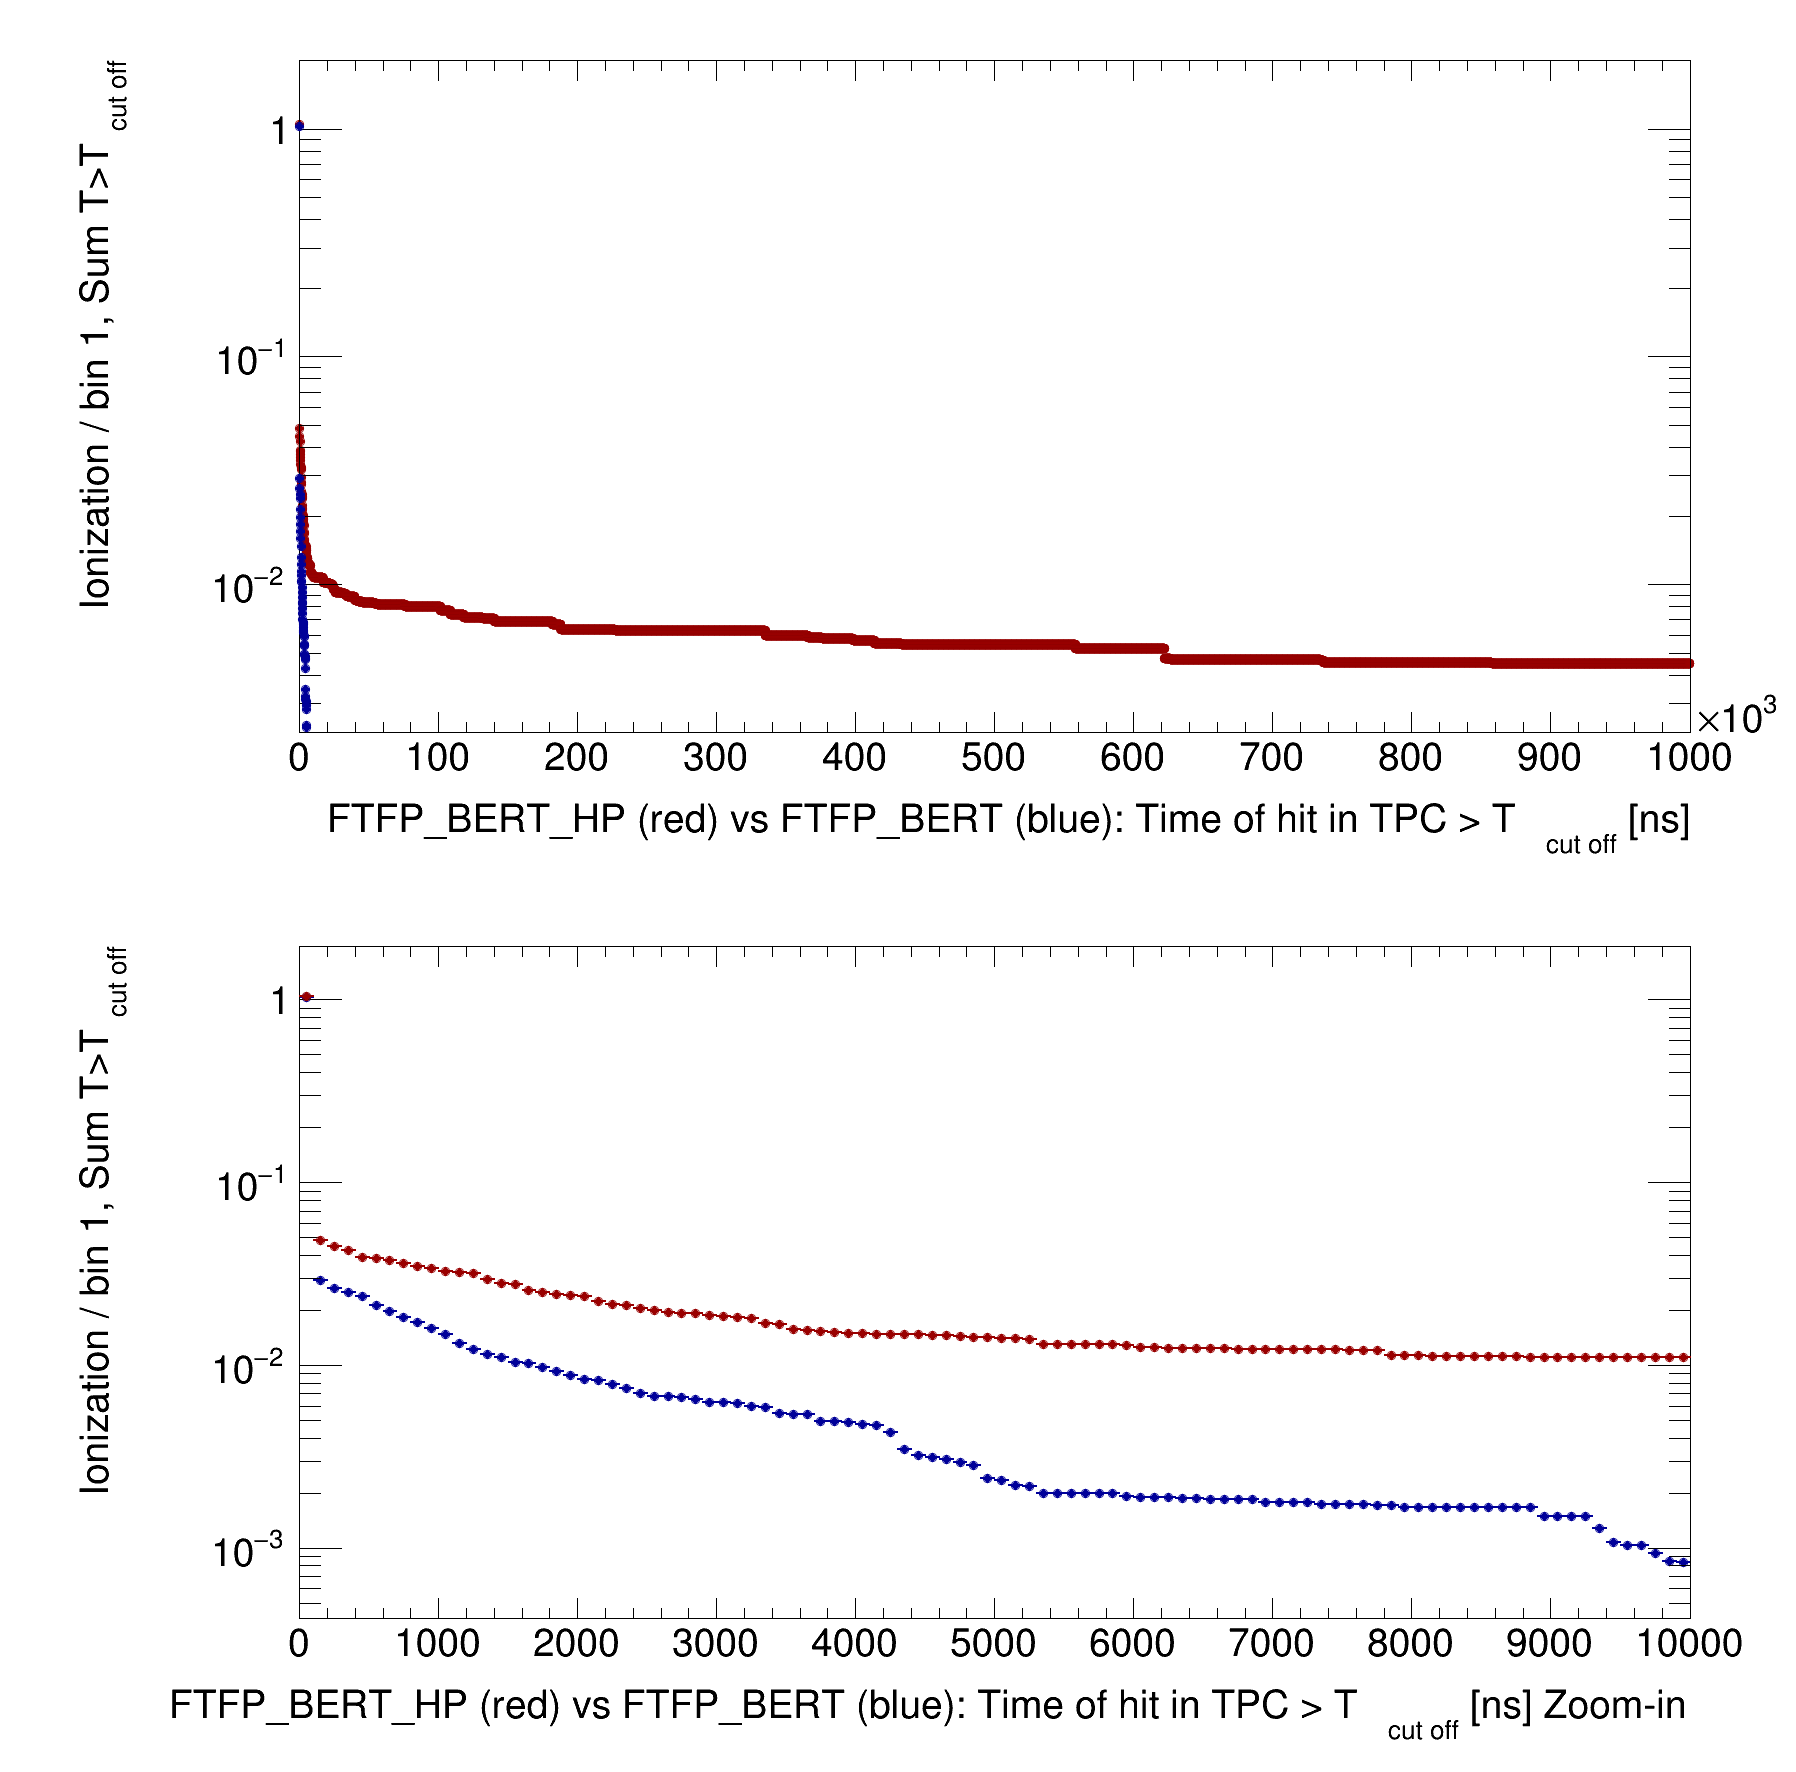

In [17]:
%%cpp
{

    auto c1 = new TCanvas(TString("TimeIntegral") ,
                        TString("TimeIntegral"),
                        1800, 1800);

    c1->Divide(1, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        TH1 * h = (TH1 *)h_eIonTPCHitTime_HP_NormalizedIntegral->DrawClone();
        h->SetTitle(";FTFP_BERT_HP (red) vs FTFP_BERT (blue): Time of hit in TPC > T_{cut off} [ns];Ionization / bin 1, Sum T>T_{cut off}");
        h_eIonTPCHitTime_NormalizedIntegral->DrawClone("SAME");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        TH1 * h = (TH1 *) h_eIonTPCHitTime_NormalizedIntegral->DrawClone();
        h->SetTitle(";FTFP_BERT_HP (red) vs FTFP_BERT (blue): Time of hit in TPC > T_{cut off} [ns] Zoom-in;Ionization / bin 1, Sum T>T_{cut off}");
        h_eIonTPCHitTime_HP_NormalizedIntegral->DrawClone("SAME");
        h->GetXaxis()->SetRangeUser(0,10000);
    }

    
    c1->Draw();
}

# Discussion

* The majority of the ionization energy, 95%, in TPC is within first bin (100 ns)
* There is a small but visible tail, at O(1) percent level, that extend to very long after the collision. 
* Although the tail is small for one collision, consider there are 50 AuAu collisions for 1us, the sum of their delayed hit are comparable to a fraction of the hit load of one collision: 
  - For example, `1ms * 50kHz * 1% late component` = 0.5 collision worth of hit from late component of previous collisions. 

This could be a noticable source of TPC hit charge that is not yet accounted in our tracking simulation. Nonetheless, it is impractical to keep track of Geant4 interaction far (miliseconds) back in time with `FTFP_BERT_HP` physics list. 

One solution is to make a simulation time cut off, e.g. `T_cutoff= 1us`: 
* Below T_cutoff, use Geant4 simulation to keep track of all hits, primary interaction or not. 
* Beyond T_cutoff, the build up a probability map of late-neutron interactions in the TPC and sample from this map  to stocastically assemble one background frame as additional backgorund source for embedding

Warning in <TCanvas::Constructor>: Deleting canvas with same name: HitLocation
Warning in <TFile::Append>: Replacing existing TH1: h_eIonTPCHitPosOnTime_HP (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: h_eIonTPCHitPosOnTime_HP (Potential memory leak).


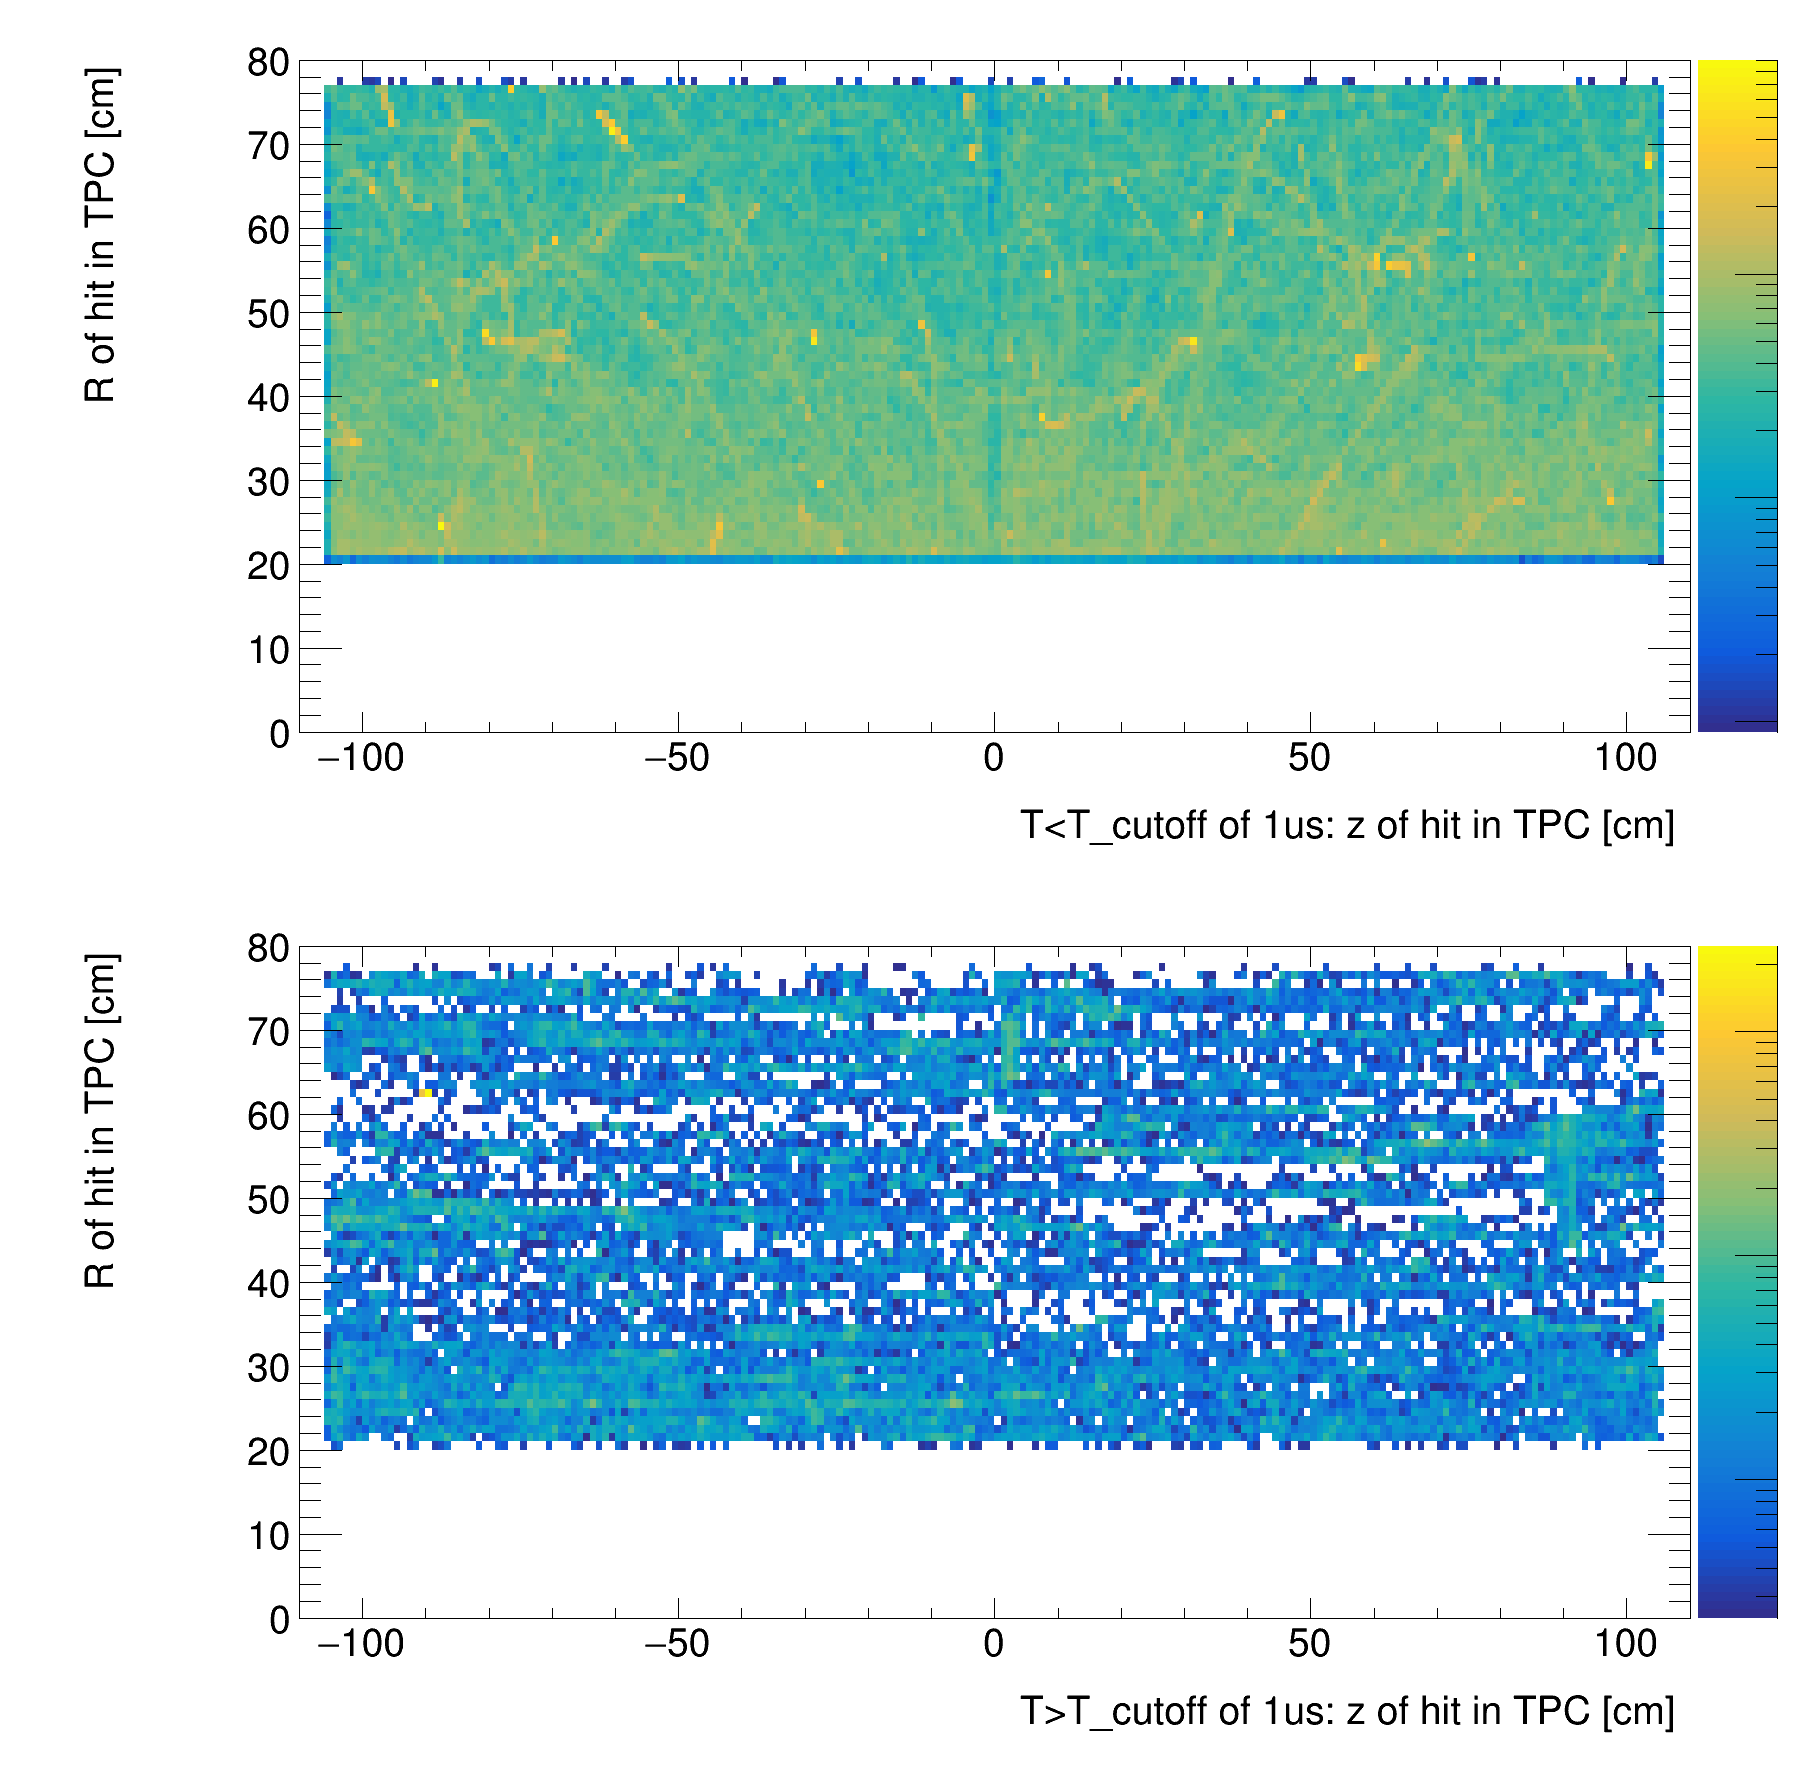

In [26]:
%%cpp

{

    auto c1 = new TCanvas(TString("HitLocation") ,
                        TString("HitLocation"),
                        1800, 1800);

    c1->Divide(1, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        TH2 * h_eIonTPCHitPosOnTime_HP = new TH2F("h_eIonTPCHitPosOnTime_HP",";T<T_cutoff of 1us: z of hit in TPC [cm];R of hit in TPC [cm]",220,-110,110,80,0,80);

        T_HP->Draw("sqrt(G4HIT_TPC[].x[0]**2 + G4HIT_TPC[].y[0]**2):G4HIT_TPC[].z[0]>>h_eIonTPCHitPosOnTime_HP","G4HIT_TPC[].edep * ( G4HIT_TPC[].t[0]<1e3 )","colz");
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogz();
        TH2 * h_eIonTPCHitPosOnTime_HP = new TH2F("h_eIonTPCHitPosOnTime_HP",";T>T_cutoff of 1us: z of hit in TPC [cm];R of hit in TPC [cm]",220,-110,110,80,0,80);

        T_HP->Draw("sqrt(G4HIT_TPC[].x[0]**2 + G4HIT_TPC[].y[0]**2):G4HIT_TPC[].z[0]>>h_eIonTPCHitPosOnTime_HP","G4HIT_TPC[].edep * ( G4HIT_TPC[].t[0]>1e3 )","colz");
    }

    
    c1->Draw();
}

In [12]:
%%cpp
T_pi->Show(2);

input_line_260:2:3: error: use of undeclared identifier 'T_pi'
 (T_pi->Show(2))
  ^
Error in <HandleInterpreterException>: Error evaluating expression (T_pi->Show(2)).
Execution of your code was aborted.


In [13]:
%%cpp

{
    
    const char *hist_name_prefix = "TowerPatch_HCAL";
    auto c1 = new TCanvas(TString("TowerPatch_HCAL") ,
                        TString("TowerPatch_HCAL"),
                        1800, 700);

    c1->Divide(2, 1);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        //p->SetLogz();
        p->SetRightMargin(0.2);
        
        
        TH2F * hpatch2D_mu = new TH2F("hpatch2D_mu",";#mu^{+}: #eta bin in Outer Hcal patch;#mu^{+}: #phi bin in Outer Hcal patch;Average tower energy [GeV]",7,-3.5,3.5,7,-3.5,3.5);
        T_mu->Draw("HCALOUT_Tower_iPhi_patch:HCALOUT_Tower_iEta_patch>>hpatch2D_mu","HCALOUT_Tower_E","colz");
        hpatch2D_mu->Scale(1. / hpatch2D_mu->GetSum());
        
        
      TLegend *leg = new TLegend(.2,.75,.7,.93, "#splitline{#splitline{#it{#bf{ECCE}} Simulation}{Single particle in barrel calo.}}{|#eta|<1, 0.5<p<20 GeV}");
      // leg->AddEntry("","","");
      leg->Draw();
        
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        //p->SetLogz();
        p->SetRightMargin(0.2);
        
        TH2F * hpatch2D_pi = new TH2F("hpatch2D_pi",";#pi^{+}: #eta bin in Outer Hcal patch;#pi^{+}: #phi bin in Outer Hcal patch;Average tower energy [GeV]",7,-3.5,3.5,7,-3.5,3.5);
        T_pi->Draw("HCALOUT_Tower_iPhi_patch:HCALOUT_Tower_iEta_patch>>hpatch2D_pi","HCALOUT_Tower_E","colz");
                hpatch2D_pi->Scale(1. / hpatch2D_pi->GetSum());

    }


    c1->Draw(); 
      c1->Print("TowerPatch_HCAL.pdf");
      c1->Print("TowerPatch_HCAL.png");
}

input_line_262:2:3: error: use of undeclared identifier 'T_mu'
 (T_mu->Draw("HCALOUT_Tower_iPhi_patch:HCALOUT_Tower_iEta_patch>>hpatch2D_mu", "HCALOUT_Tower_E", "colz"))
  ^
Error in <HandleInterpreterException>: Error evaluating expression (T_mu->Draw("HCALOUT_Tower_iPhi_patch:HCALOUT_Tower_iEta_patch>>hpatch2D_mu", "HCALOUT_Tower_E", "colz")).
Execution of your code was aborted.


In [14]:
%%cpp

{

    
    const char *hist_name_prefix = "CaloStack";
    auto c1 = new TCanvas(TString("CaloStack") ,
                        TString("CaloStack"),
                        1800, 1550);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        TH1F * BECAL_hE7x7pTruth = new TH1F("BECAL_hE7x7pTruth",";Barrel EMCal E_{Sum7x7} [GeV];Probability per bin",100,0,1.5);
        T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth","m_truthp>3","goff");
        BECAL_hE7x7pTruth->Scale(1. / BECAL_hE7x7pTruth->GetSum());
        
        TH1F * BECAL_hE7x7pTruth_pi = new TH1F("BECAL_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,1.5);
        T_pi->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth_pi","m_truthp>3","goff");
        BECAL_hE7x7pTruth_pi->Scale(1. / BECAL_hE7x7pTruth_pi->GetSum());
        
        BECAL_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        BECAL_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        BECAL_hE7x7pTruth->SetMarkerColor(kRed+2);
        BECAL_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        BECAL_hE7x7pTruth->SetLineColor(kRed+2);
        BECAL_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        BECAL_hE7x7pTruth->Draw();
        BECAL_hE7x7pTruth_pi->Draw("same");
        
        
      TLegend *leg = new TLegend(.43,.6,.9,.87, "#splitline{#splitline{#it{#bf{ECCE}} Simulation}{Single particle in barrel calo.}}{|#eta|<1, 3<p<20 GeV}");
      leg->AddEntry(BECAL_hE7x7pTruth,"#mu^{+}","pl");
      leg->AddEntry(BECAL_hE7x7pTruth_pi,"#pi^{+}","pl");
      leg->Draw();
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("HCALIN_hE7x7pTruth",";HCALIN_E_{7x7}",100,0,1.5);
        //T_mu->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth","m_truthp>3");
        
        
        
        TH1F * HCALIN_hE7x7pTruth = new TH1F("HCALIN_hE7x7pTruth",";Inner HCal E_{Sum7x7} [GeV];Probability per bin",50,0,1.5);
        T_mu->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth","m_truthp>3","goff");
        HCALIN_hE7x7pTruth->Scale(1. / HCALIN_hE7x7pTruth->GetSum());
        
        TH1F * HCALIN_hE7x7pTruth_pi = new TH1F("HCALIN_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",50,0,1.5);
        T_pi->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth_pi","m_truthp>3","goff");
        HCALIN_hE7x7pTruth_pi->Scale(1. / HCALIN_hE7x7pTruth_pi->GetSum());
        
        HCALIN_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        HCALIN_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        HCALIN_hE7x7pTruth->SetMarkerColor(kRed+2);
        HCALIN_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        HCALIN_hE7x7pTruth->SetLineColor(kRed+2);
        HCALIN_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        HCALIN_hE7x7pTruth->Draw();
        HCALIN_hE7x7pTruth_pi->Draw("same");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("HCALOUT_hE7x7pTruth",";HCALOUT_E_{7x7}",100,0,5);
        //T_mu->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth","m_truthp>3");
        
        
        
        TH1F * HCALOUT_hE7x7pTruth = new TH1F("HCALOUT_hE7x7pTruth",";Outer HCal E_{Sum7x7} [GeV];Probability per bin",100,0,5);
        T_mu->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth","m_truthp>3","goff");
        HCALOUT_hE7x7pTruth->Scale(1. / HCALOUT_hE7x7pTruth->GetSum());
        
        TH1F * HCALOUT_hE7x7pTruth_pi = new TH1F("HCALOUT_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,5);
        T_pi->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth_pi","m_truthp>3","goff");
        HCALOUT_hE7x7pTruth_pi->Scale(1. / HCALOUT_hE7x7pTruth_pi->GetSum());
        
        HCALOUT_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        HCALOUT_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        HCALOUT_hE7x7pTruth->SetMarkerColor(kRed+2);
        HCALOUT_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        HCALOUT_hE7x7pTruth->SetLineColor(kRed+2);
        HCALOUT_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        HCALOUT_hE7x7pTruth->Draw();
        HCALOUT_hE7x7pTruth_pi->Draw("same");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("SUM_hE7x7pTruth",";SUM_E_{7x7}",100,0,5);
        //T_mu->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth","m_truthp>3");
        
        
        
        TH1F * SUM_hE7x7pTruth = new TH1F("SUM_hE7x7pTruth",";Outer HCal E_{Sum7x7} [GeV];Probability per bin",100,0,5);
        T_mu->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth","m_truthp>3","goff");
        SUM_hE7x7pTruth->Scale(1. / SUM_hE7x7pTruth->GetSum());
        
        TH1F * SUM_hE7x7pTruth_pi = new TH1F("SUM_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,5);
        T_pi->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth_pi","m_truthp>3","goff");
        SUM_hE7x7pTruth_pi->Scale(1. / SUM_hE7x7pTruth_pi->GetSum());
        
        SUM_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        SUM_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        SUM_hE7x7pTruth->SetMarkerColor(kRed+2);
        SUM_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        SUM_hE7x7pTruth->SetLineColor(kRed+2);
        SUM_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        SUM_hE7x7pTruth->Draw();
        SUM_hE7x7pTruth_pi->Draw("same");
    }
    
    
    
    c1->Draw();
      c1->Print("CaloStack3.pdf");
      c1->Print("CaloStack3.png");
}

input_line_264:2:3: error: use of undeclared identifier 'T_mu'
 (T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth", "m_truthp>3", "goff"))
  ^
Error in <HandleInterpreterException>: Error evaluating expression (T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth", "m_truthp>3", "goff")).
Execution of your code was aborted.


In [15]:
%%cpp

{

    
    const char *hist_name_prefix = "CaloStack";
    auto c1 = new TCanvas(TString("CaloStack") ,
                        TString("CaloStack"),
                        1800, 1550);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        TH1F * BECAL_hE7x7pTruth = new TH1F("BECAL_hE7x7pTruth",";Barrel EMCal E_{Sum7x7} [GeV];Probability per bin",100,0,1.5);
        T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth","m_truthp>0.5","goff");
        BECAL_hE7x7pTruth->Scale(1. / BECAL_hE7x7pTruth->GetSum());
        
        TH1F * BECAL_hE7x7pTruth_pi = new TH1F("BECAL_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,1.5);
        T_pi->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth_pi","m_truthp>0.5","goff");
        BECAL_hE7x7pTruth_pi->Scale(1. / BECAL_hE7x7pTruth_pi->GetSum());
        
        BECAL_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        BECAL_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        BECAL_hE7x7pTruth->SetMarkerColor(kRed+2);
        BECAL_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        BECAL_hE7x7pTruth->SetLineColor(kRed+2);
        BECAL_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        BECAL_hE7x7pTruth->Draw();
        BECAL_hE7x7pTruth_pi->Draw("same");
        
        
      TLegend *leg = new TLegend(.43,.65,.9,.83, "#splitline{#splitline{#it{#bf{ECCE}} Simulation}{Single particle in barrel calo.}}{|#eta|<1, 0.5<p<20 GeV}");
      leg->AddEntry("","","");
      leg->AddEntry(BECAL_hE7x7pTruth,"#mu^{+}","pl");
      leg->AddEntry(BECAL_hE7x7pTruth_pi,"#pi^{+}","pl");
      leg->Draw();
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("HCALIN_hE7x7pTruth",";HCALIN_E_{7x7}",100,0,1.5);
        //T_mu->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth","m_truthp>0.5");
        
        
        
        TH1F * HCALIN_hE7x7pTruth = new TH1F("HCALIN_hE7x7pTruth",";Inner HCal E_{Sum7x7} [GeV];Probability per bin",50,0,1.5);
        T_mu->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth","m_truthp>0.5","goff");
        HCALIN_hE7x7pTruth->Scale(1. / HCALIN_hE7x7pTruth->GetSum());
        
        TH1F * HCALIN_hE7x7pTruth_pi = new TH1F("HCALIN_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",50,0,1.5);
        T_pi->Draw("HCALIN_Tower_E7x7>>HCALIN_hE7x7pTruth_pi","m_truthp>0.5","goff");
        HCALIN_hE7x7pTruth_pi->Scale(1. / HCALIN_hE7x7pTruth_pi->GetSum());
        
        HCALIN_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        HCALIN_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        HCALIN_hE7x7pTruth->SetMarkerColor(kRed+2);
        HCALIN_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        HCALIN_hE7x7pTruth->SetLineColor(kRed+2);
        HCALIN_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        HCALIN_hE7x7pTruth->Draw();
        HCALIN_hE7x7pTruth_pi->Draw("same");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("HCALOUT_hE7x7pTruth",";HCALOUT_E_{7x7}",100,0,5);
        //T_mu->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth","m_truthp>0.5");
        
        
        
        TH1F * HCALOUT_hE7x7pTruth = new TH1F("HCALOUT_hE7x7pTruth",";Outer HCal E_{Sum7x7} [GeV];Probability per bin",100,0,5);
        T_mu->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth","m_truthp>0.5","goff");
        HCALOUT_hE7x7pTruth->Scale(1. / HCALOUT_hE7x7pTruth->GetSum());
        
        TH1F * HCALOUT_hE7x7pTruth_pi = new TH1F("HCALOUT_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,5);
        T_pi->Draw("HCALOUT_Tower_E7x7>>HCALOUT_hE7x7pTruth_pi","m_truthp>0.5","goff");
        HCALOUT_hE7x7pTruth_pi->Scale(1. / HCALOUT_hE7x7pTruth_pi->GetSum());
        
        HCALOUT_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        HCALOUT_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        HCALOUT_hE7x7pTruth->SetMarkerColor(kRed+2);
        HCALOUT_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        HCALOUT_hE7x7pTruth->SetLineColor(kRed+2);
        HCALOUT_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        HCALOUT_hE7x7pTruth->Draw();
        HCALOUT_hE7x7pTruth_pi->Draw("same");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        //new TH1F("SUM_hE7x7pTruth",";SUM_E_{7x7}",100,0,5);
        //T_mu->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth","m_truthp>0.5");
        
        
        
        TH1F * SUM_hE7x7pTruth = new TH1F("SUM_hE7x7pTruth",";Sum of all calorimeters E_{Sum7x7} [GeV];Probability per bin",100,0,5);
        T_mu->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth","m_truthp>0.5","goff");
        SUM_hE7x7pTruth->Scale(1. / SUM_hE7x7pTruth->GetSum());
        
        TH1F * SUM_hE7x7pTruth_pi = new TH1F("SUM_hE7x7pTruth_pi",";Barrel EMCal E_{Sum7x7} [GeV]",100,0,5);
        T_pi->Draw("BECAL_Tower_E7x7 + HCALIN_Tower_E7x7 + HCALOUT_Tower_E7x7>>SUM_hE7x7pTruth_pi","m_truthp>0.5","goff");
        SUM_hE7x7pTruth_pi->Scale(1. / SUM_hE7x7pTruth_pi->GetSum());
        
        SUM_hE7x7pTruth->SetMarkerStyle(kOpenCircle);
        SUM_hE7x7pTruth_pi->SetMarkerStyle(kFullCircle);
        SUM_hE7x7pTruth->SetMarkerColor(kRed+2);
        SUM_hE7x7pTruth_pi->SetMarkerColor(kBlue+1);
        SUM_hE7x7pTruth->SetLineColor(kRed+2);
        SUM_hE7x7pTruth_pi->SetLineColor(kBlue+1);
        
        
        SUM_hE7x7pTruth->Draw();
        SUM_hE7x7pTruth_pi->Draw("same");
    }
    
    
    
    c1->Draw();
      c1->Print("CaloStack.pdf");
      c1->Print("CaloStack.png");
}

Warning in <TCanvas::Constructor>: Deleting canvas with same name: CaloStack
Warning in <TFile::Append>: Replacing existing TH1: BECAL_hE7x7pTruth (Potential memory leak).
input_line_266:2:3: error: use of undeclared identifier 'T_mu'
 (T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth", "m_truthp>0.5", "goff"))
  ^
Error in <HandleInterpreterException>: Error evaluating expression (T_mu->Draw("BECAL_Tower_E7x7>>BECAL_hE7x7pTruth", "m_truthp>0.5", "goff")).
Execution of your code was aborted.
